In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts
import scipy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 

import time


In [2]:
%matplotlib widget

### This Notebook explores improvements to solving the quadratic problem

Some challenges:
1. If we search over all features, the problem is much to large to handle
2. Occasionally, the solver will not converge. Terminating with 'Singular or KKT matrix error' meaning the problem is not convex

Some potential solutions:
1. Reducing computational size
    - Make the matrices sparse, perhaps we will still get a good enough answer s.t. when we reduce the feature bank we end up with the same features. We can make P sparse, or try to make feature bank and cov (or invcov) sparse. 
    - Randomly solving for elements of the larger problem
    - Leveraging the low rank properties of our P matrix
    - A better way to reduce the 'size' of A is to take the first k elements from a singular value decomposition


2. Sovler not converging
    - Rescale the size of the problem 
        - scaling will also allow for finer precision
    - Generally a few large values in the constraints will cause issues:
        - norm(A) < 1 helps where A is constraint matrix
        - Redundant constraints box-type constraints x[k] <= u for large u
        - Big-M type penalty terms
        - Ax=b where a few b[k] are very large,  or a few A[k,j] are very large


Model 'true' already exists in pw.exp, bypassing pointwise reconstruction
Model 'true' already exists in pw.fine, bypassing pointwise reconstruction


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

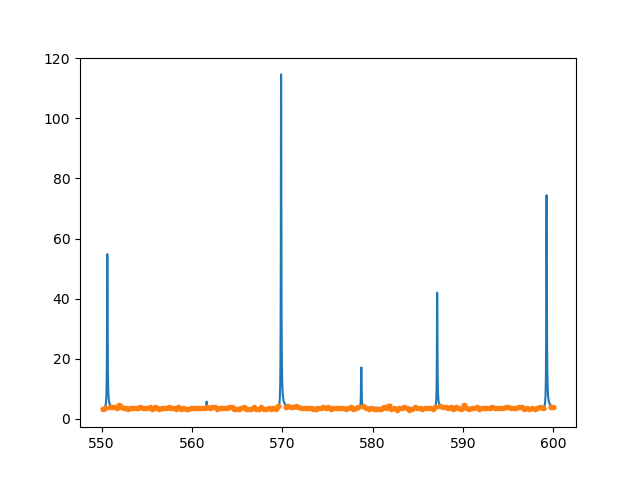

In [3]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.9,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)


from ATARI.utils.io.experimental_parameters import BuildExperimentalParameters_fromDIRECT, DirectExperimentalParameters
from ATARI.utils.io.theoretical_parameters import BuildTheoreticalParameters_fromHDF5, BuildTheoreticalParameters_fromATARI, DirectTheoreticalParameters
from ATARI.utils.io.pointwise_container import BuildPointwiseContainer_fromHDF5, BuildPointwiseContainer_fromATARI, DirectPointwiseContainer
from ATARI.utils.io.data_container import BuildDataContainer_fromBUILDERS, BuildDataContainer_fromOBJECTS, DirectDataContainer

# build theoretical parameters
builder_theo_par = BuildTheoreticalParameters_fromATARI('true', resonance_ladder, Ta_pair)
theo_par = builder_theo_par.construct()
theo_par.fill()

# build experimental parameters
builder_exp_par = BuildExperimentalParameters_fromDIRECT(exp.redpar.val.n, 0, 1e-2)
exp_par = builder_exp_par.construct()

# build pointwise data
builder_pw = BuildPointwiseContainer_fromATARI(exp.trans, CovT=exp.CovT, ppeV=100)
pw = builder_pw.construct_full()
pw.add_model(theo_par, exp_par, overwrite=True)
pw.fill_exp_xs(exp_par)

# build data container
builder_dc = BuildDataContainer_fromOBJECTS(pw, exp_par, [theo_par])
dc = builder_dc.construct()
# dc.pw.add_model(theo_par, exp_par)

figure()
plot(dc.pw.fine.E, dc.pw.fine.true_xs)
errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# ylim([-max_xs*.1, max_xs*1.25])

In [4]:
# average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
# Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e0)
# # Gtot_features = np.round(np.array(resonance_ladder.Gt),1)*1e-3
# # Elam_features = np.round(np.array(resonance_ladder.E),1)
# # Elam_features = Elam_features[0:int(len(Elam_features)/2)]
# # Gtot_features = Gtot_features[::2]

# # get resonance feature matrix
# Resonance_Matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(dc.pw.exp.E, Ta_pair, Elam_features, Gtot_features)
# nfeatures = np.shape(Resonance_Matrix)[1]
# print(nfeatures)
# # print(Gtot_features)

In [5]:
import classes as cls

### Step 0
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(dc.pw.exp.E, average_parameters, '3.0', 1e-1, 3e0)
# Gtot_features = np.append(Gtot_features, np.round(np.array(dc.theoretical_parameters['true'].resonance_ladder.Gt),1)*1e-3 )
# Elam_features = np.append(Elam_features, np.round(np.array(dc.theoretical_parameters['true'].resonance_ladder.E),1))
# Elam_features = np.round(np.array(theo_resladder.E),1)
# Gtot_features = np.array(theo_resladder.Gt)*1e-3
# Elam_features = np.array(theo_resladder.E)

w_threshold = 1e-6
prob = cls.ProblemHandler(w_threshold)

fb0 = prob.get_FeatureBank(dc, Elam_features, Gtot_features)
inp0 = prob.get_MatrixInputs(dc, fb0)

print(fb0.nfeatures)


# start_time = time.time()

# unconstrained_w = solve_qp(inp0.P, inp0.q, G=inp0.G, h=inp0.h, A=None, b=None, lb=inp0.lb, ub=inp0.ub, 
#                                                                 solver="cvxopt",
#                                                                 verbose=True)


# end_time = time.time()
# execution_time = end_time - start_time
# print(f"time for full matrix solve is {execution_time}")

6500


In [6]:
### Quick test of speedup on sparse matrices

# q90 = np.quantile(abs(inp0.P.flatten()), .5)
# P0 = inp0.P.copy()
# P0[abs(inp0.P)<q90] = 0
# P0_sparse = scipy.sparse.csc_matrix(P0)
# q_sparse = inp0.q # scipy.sparse.csc_matrix(inp0.q)

# print(P0.data.nbytes)
# print(P0_sparse.data.nbytes)
# print(inp0.q.data.nbytes)
# print(q_sparse.data.nbytes)

# figure()
# bins = hist(np.log10(abs(inp0.P.flatten())), bins =100, density=True)
# axvline(np.log10(min(abs(P0)[P0!=0].flatten())), color='r')
# # bins = hist(np.log10(abs(P0[P0!=0].flatten())), bins =100, color='r', density=True)


# unconstrained_w_sparse = solve_qp(P0_sparse, inp0.q, G=None, h=None, A=None, b=None, lb=inp0.lb, ub=inp0.ub, 
#                                                                 # solver="cvxopt",
#                                                                 solver="osqp", verbose=True)
# # unconstrained_w = solve_qp(P0, inp0.q, G=inp0.G, h=inp0.h, A=None, b=None, lb=inp0.lb, ub=inp0.ub, 
# #                                                                 solver="cvxopt",
# #                                                                 verbose=True)

### Reduce size using lp solve first

In [7]:
# P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), max_xs, Resonance_Matrix)
# lp_unconstrained_w = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)
# print(np.count_nonzero(lp_unconstrained_w.x>0))

# reduced_feature_matrix, reduced_feature_pairs = fn.get_reduced_feature_matrix(Resonance_Matrix, lp_unconstrained_w.x, 1e-1, feature_pairs)

# P_reduced, q_reduced, G_reduced, h_reduced, lb_reduced, ub_reduced, index_0T_reduced = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), 
#                                                                                                             max_xs, reduced_feature_matrix)

# unconstrained_solw_reduced = solve_qp(P_reduced, q_reduced, G=G_reduced, h=h_reduced, A=None, b=None, lb=lb_reduced, ub=ub_reduced, 
#                                                                                                 solver="cvxopt",
#                                                                                                 verbose=True,
#                                                                                                 abstol=1e-12,
#                                                                                                 reltol=1e-12,
#                                                                                                 feastol= 1e-8,
#                                                                                                 maxiters = 100)
# unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
#                                                                 solver="cvxopt",
#                                                                 # solver="scs",
#                                                                 verbose=True,
#                                                                 abstol=1e-10,
#                                                                 reltol=1e-10,
#                                                                 feastol= 1e-7,
#                                                                 maxiters = 200)

# figure()
# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
# # plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
# # plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten())
# plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_solw_reduced+potential_scattering.flatten())
# ylim([-max_xs*.1, max_xs*1.25])

### Approximate as Sparse Matrices

In [14]:
### consider using a sparse matrix solver and just forcing elements of P to zero below some threshold
# can also make resonance matrix and datacov sparse (can make datacov or invdatacov sparse)


# figure()
# plot(np.array(Resonance_Matrix)[100,:])
# imshow(np.log10(np.array(dc.CovXS)))
# plot(np.diag(np.array(dc.CovXS)))
def get_qp_inputs_sparse(exp_E, exp_xs, cov_xs, potential_scattering, max_xs, feature_matrix, feature_pairs, particle_pair, qsparse):
    nfeatures = np.shape(feature_matrix)[1]
    
    # remove nan values in xs and cov for solver
    b, cov, pscat, A, index_0T = fn.remove_nan_values(exp_xs, cov_xs, potential_scattering, feature_matrix)
    b = b-pscat
    b_sparse = scipy.sparse.csc_matrix(b)

    # get bounds and constraints
    lb, ub = fn.get_bound_arrays(nfeatures, (0,1) )
    G, h = fn.get_0Trans_constraint(exp_E, index_0T, max_xs, particle_pair, feature_pairs)
    G_sparse = scipy.sparse.csc_matrix(G)
    # h = scipy.sparse.csc_matrix(h)

    # make A and cov sparse
    A_0 = A.copy()
    A_0[abs(A_0)<np.quantile(abs(A_0), qsparse)] = 0 #30
    A_sparse = scipy.sparse.csc_matrix(A_0)
    cov_0 = np.array(cov).copy()
    cov_0[abs(cov_0)<np.quantile(abs(cov_0), qsparse)] = 0  #0.02
    cov_sparse = scipy.sparse.csc_matrix(cov_0)

    # Cast into quadratic program 
    P0 = A_0.T @ inv(cov_0) @ A_0
    P_sparse = A_sparse.T @ scipy.sparse.linalg.inv(cov_sparse) @ A_sparse
    q0 = - A_0.T @ inv(cov_0) @ b
    q = - A_sparse.T @ scipy.sparse.linalg.inv(cov_sparse) @ b

    return P0, q0, G, P_sparse, q, G_sparse, h, lb, ub, index_0T


In [15]:
P0,q0, G, P_sparse, q_sparse, G_sparse, h_sparse, lb_sparse, ub_sparse, index_0T_sparse = get_qp_inputs_sparse(np.array(dc.pw.exp.E), np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), 
                                                                                                        fb0.potential_scattering, dc.experimental_parameters.max_xs, fb0.feature_matrix, fb0.feature_pairs, Ta_pair,
                                                                                                        0.998)


In [16]:
import qpsolvers
print(qpsolvers.available_solvers)

['clarabel', 'cvxopt', 'ecos', 'osqp', 'proxqp', 'qpoases', 'scs']


In [19]:
print(G.size)
print(G_sparse.size)

print(P_sparse.data.nbytes/P0.data.nbytes)
50/1.8
np.shape(G)

195000
195000
0.9246371124260355


(30, 6500)

In [20]:

### sparse solve
start_time = time.time()
unconstrained_w_sparse = solve_qp(P_sparse, q_sparse, G=G_sparse, h=h_sparse, A=None, b=None, lb=lb_sparse, ub=ub_sparse, 
                                                                # solver="cvxopt",
                                                                solver="clarabel", verbose=True)
end_time = time.time()
execution_time = end_time - start_time
print(f"time for sparse matrix solve is {execution_time}")


-------------------------------------------------------------
           Clarabel.rs v0.5.1  -  Clever Acronym              

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 6500
  constraints   = 13030
  nnz(P)        = 19536209
  nnz(A)        = 208000
  cones (total) = 1
    : Nonnegative = 1,  numel = 13030

settings:
  linear algebra: direct / qdldl, precision: 64 bit
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, max_scale = 1.0e4
               max iter = 10

iter    pcost        dcost       gap       pres      dres     

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/qpsolvers/solvers/clarabel_.py:142: UserWarning: Clarabel.rs terminated with status NumericalError
  warnings.warn(f"Clarabel.rs terminated with status {result.status}")


In [21]:
start_time = time.time()
unconstrained_w_sparse = solve_qp(P0, q0, G=G, h=h_sparse, A=None, b=None, lb=lb_sparse, ub=ub_sparse, 
                                                                    solver="cvxopt", verbose=True)
end_time = time.time()
execution_time = end_time - start_time
print(f"time for full matrix solve is {execution_time}")

     pcost       dcost       gap    pres   dres
 0: -1.0918e+02 -1.0659e+04  5e+04  2e+00  5e-01
 1: -1.0918e+02 -6.0374e+03  1e+04  4e-01  1e-01
 2: -1.0918e+02 -3.5051e+03  7e+03  2e-01  5e-02
 3: -1.0918e+02 -3.4157e+03  6e+03  2e-01  4e-02
 4: -1.0918e+02 -1.6173e+03  3e+03  6e-02  1e-02
 5: -1.0918e+02 -1.4832e+03  2e+03  5e-02  1e-02
 6: -1.0918e+02 -5.5685e+02  8e+02  1e-02  3e-03
 7: -1.0918e+02 -2.9195e+02  3e+02  5e-03  1e-03
 8: -1.0918e+02 -2.1528e+02  2e+02  2e-03  6e-04
 9: -1.0918e+02 -1.6782e+02  9e+01  1e-03  3e-04
10: -1.0918e+02 -1.4159e+02  5e+01  5e-04  1e-04
11: -1.0918e+02 -1.3483e+02  4e+01  3e-04  6e-05
12: -1.0918e+02 -1.2527e+02  2e+01  1e-04  3e-05
13: -1.0918e+02 -1.1399e+02  7e+00  2e-05  6e-06
14: -1.0918e+02 -1.1001e+02  1e+00  4e-06  1e-06
15: -1.0918e+02 -1.0989e+02  1e+00  3e-06  8e-07
16: -1.0918e+02 -1.0980e+02  1e+00  3e-06  8e-07
17: -1.0918e+02 -1.0960e+02  1e+00  3e-06  8e-07
18: -1.0917e+02 -1.0937e+02  1e+00  3e-06  7e-07
19: -1.0911e+02 -1.08

In [11]:

# time_dict = {}

# for q in [0.85, .9, .95, .98, 0.99]:

#     print(q)
    
#     P0,q0, G, P_sparse, q_sparse, G_sparse, h_sparse, lb_sparse, ub_sparse, index_0T_sparse = get_qp_inputs_sparse(np.array(dc.pw.exp.E), np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), 
#                                                                                                         fb0.potential_scattering, dc.experimental_parameters.max_xs, fb0.feature_matrix, fb0.feature_pairs, Ta_pair,
#                                                                                                         q)
#     try:
#         ### sparse solve
#         start_time = time.time()
#         unconstrained_w_sparse = solve_qp(P_sparse, q_sparse, G=G_sparse, h=h_sparse, A=None, b=None, lb=lb_sparse, ub=ub_sparse, 
#                                                                         # solver="cvxopt",
#                                                                         solver="osqp", verbose=True)
#         end_time = time.time()
#         execution_time = end_time - start_time
#         print(f"time for sparse matrix solve is {execution_time}")


#         ### full solve
#         start_time_full = time.time()
#         unconstrained_w_sparse = solve_qp(P0, q0, G=G, h=h_sparse, A=None, b=None, lb=lb_sparse, ub=ub_sparse, 
#                                                                         solver="cvxopt", verbose=True)
#         end_time_full = time.time() 
#         execution_time_full = end_time_full - start_time_full
#         print(f"time for full matrix solve is {execution_time_full}")

#         time_dict[q] = (execution_time, execution_time_full)

#     except:
#         print(f"Quantile {q} failed.")

0.85
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6500, constraints m = 6502
          nnz(P) + nnz(A) = 21147750
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.0157e+02   7.47e+00   1.42e+06   1.00e-01   3.37e+01s
  25  -4.6973e+02   9.44e-05   1.57e+02   1.00e-01   3.47e+01s

status:               solved
num

In [ ]:
print(inp0.P.data.nbytes)
print(P_sparse.data.nbytes)
print(P_sparse.data.nbytes/inp0.P.data.nbytes)

338000000
48054672
0.14217358579881656


In [22]:
list(time_dict.values())
time_dict.keys()

dict_keys([0.9, 0.98, 0.99])

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


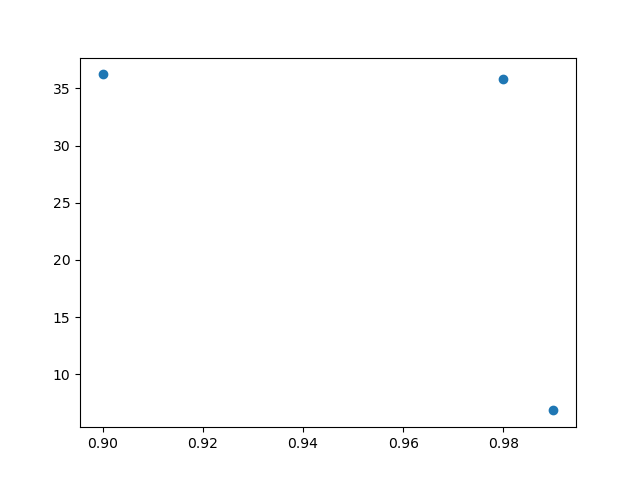

In [20]:
figure()

scatter(time_dict.keys(), np.array(list(time_dict.values()))[:, 0])

In [ ]:
# np.count_nonzero(P_sparse.)
P_sparse.data.nbytes


1354856

In [ ]:
unconstrained_w_sparse = solve_qp(P_sparse, q_sparse, G=G_sparse, h=h_sparse, A=None, b=None, lb=lb_sparse, ub=ub_sparse, 
                                                                # solver="cvxopt",
                                                                solver="osqp")#,
                                                                # verbose=True,
                                                                # abstol=1e-11,
                                                                # reltol=1e-11,
                                                                # feastol= 1e-7,
                                                                # maxiters = 200)

print(np.count_nonzero(unconstrained_w_sparse>1e-10))

811


(-0.7675283643313486, 9.594104554141857)

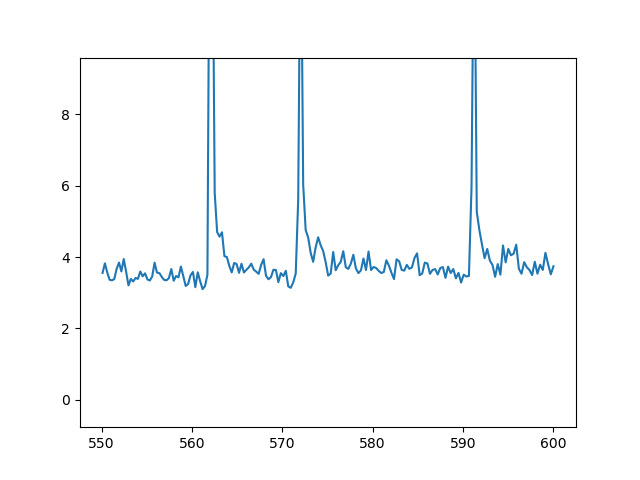

In [ ]:
figure()
# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=dc.pw_exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs)
# plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten())
plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w_sparse+potential_scattering.flatten())
ylim([-max_xs*.1, max_xs*1.25])

### Use singular value decomposition to reduce the matrix size initially

In [ ]:
### Sigular value decomp
# u, s, vh = np.linalg.svd(Resonance_Matrix)
# # np.shape(s)
# val = 10
# u10 = u[:, 0:val]
# s10 = np.diag(s[0:val])
# vh10 = vh[0:val,:]
# testa = u10 @ s10 @ vh10

# import numpy as np

# # # Define the original quadratic matrix
# # Q = np.array([[4, -2, 1],
# #               [-2, 5, -3],
# #               [1, -3, 6]])
# # # Perform Singular Value Decomposition (SVD)
# # U, S, Vt = np.linalg.svd(Q)
# # # Define the desired rank of the approximation
# # k = 2
# # # Truncate the singular values and matrices
# # Uk = U[:, :k]
# # Sk = np.diag(S[:k])
# # Vtk = Vt[:k, :]
# # # Construct the low-rank approximation of the quadratic matrix
# # Qk = Uk @ Sk @ Vtk

# P, q, G, h, lb, ub, index_0T = fn.get_qp_inputs(np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), max_xs, testa)

In [ ]:
# unconstrained_w = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
#                                                                 solver="cvxopt",
#                                                                 # solver="scs",
#                                                                 verbose=True,
#                                                                 abstol=1e-10,
#                                                                 reltol=1e-10,
#                                                                 feastol= 1e-7,
#                                                                 maxiters = 200)
# lp_unconstrained_w = linprog(q, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)

In [ ]:
# np.argwhere(lp_unconstrained_w.x>0.5).flatten()

array([ 4294,  4295,  4296, ..., 19035, 19036, 19037])